In [1]:
%cd ../

/home/gramos/Projects/MIIA-A23/code/mercury-duckling


In [11]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from PIL import Image
import cv2
import torch
import torch.functional as F
from torchvision import tv_tensors
from torchvision.datasets import CocoDetection
import torchvision.transforms.v2 as v2
from torchvision.transforms.v2.functional import to_pil_image
from torchvision.datasets import wrap_dataset_for_transforms_v2
from mercury_duckling.datasets.transforms import (
    Blobify,
    OneHotEncodeFromBlobs,
    ResizeLongestSideAndPad,
    Colormap,
    Clahe, 
    MinMaxNormalization,
    StandardizeTarget
)
from mercury_duckling.datasets import ThermalDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
transform = None
target_transform = None
transforms = v2.Compose(
    [
        v2.ToImage(),
        # v2.RandomZoomOut(fill={tv_tensors.Image: (0), "others": 0}),
        # v2.RandomIoUCrop(),
        # v2.RandomHorizontalFlip(p=0.7),
        # ResizeByCoefficient(cfg.data.coeff),
        # MinMaxNormalization(),
        # Colormap(colormap="turbo"),
        # Blobify(),
        # OneHotEncodeFromBlobs(),
        ResizeLongestSideAndPad(target_size=(256, 320)),
        # v2.ClampBoundingBoxes(),
        v2.ToDtype({tv_tensors.Image: torch.float32, "others": None}, scale=False),
    ]
)
root="../../data/merged_dataset_delam_thm"
dataset = ThermalDataset(
    root=root,
    annFile=os.path.join(root, "annotations/delamination.json"),
    transform=transform,
    target_transform=target_transform,
    transforms=transforms,
)
dataset = wrap_dataset_for_transforms_v2(
    dataset,
    target_keys=["masks", "labels", "boxes", "image_id"]
)
root="../../data/merged_dataset_concrete"
dataset_concrete = CocoDetection(
    root=root,
    annFile=os.path.join(root, "annotations/concrete.json"),
    transform=transform,
    target_transform=target_transform,
    transforms=transforms,
)
dataset_concrete = wrap_dataset_for_transforms_v2(
    dataset_concrete,
    target_keys=["masks", "labels", "boxes", "image_id"]
)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [32]:
idx = 255
input, target = dataset[idx]
print("Image ID:", target["image_id"])
print(
    "input shape:", input.shape, 
    "\ninput class:", type(input),
    "\ninput dtype:", input.dtype
)
print(
    "\ntarget shape:", target["masks"].shape,
    "\nnumber of targets:", len(target["boxes"]),
    "\ntarget class:", type(target["masks"]),
    "\ntarget dtype:", target["masks"].dtype
)

Image ID: 256
input shape: torch.Size([1, 256, 320]) 
input class: <class 'torchvision.tv_tensors._image.Image'> 
input dtype: torch.float32

target shape: torch.Size([1, 256, 320]) 
number of targets: 1 
target class: <class 'torchvision.tv_tensors._mask.Mask'> 
target dtype: torch.uint8


In [24]:
def get_visible(file_name, vis_dataset):
    vis_name = file_name.replace("IR", "VIS")
    for _, img_info in vis_dataset.coco.imgs.items():
        if img_info["file_name"] == vis_name:
            return img_info["id"]

file_name = dataset.coco.imgs[idx + 1]["file_name"]
print(file_name.replace("IR", "VIS"))
vis_input, vis_target = dataset_concrete[get_visible(file_name, dataset_concrete) - 1]

VIS04_37.jpg


In [33]:
# cmap_transform = Colormap(colormap="Greys")
normalization = MinMaxNormalization()
clahe_transform = Clahe()

input = normalization(input)
input = clahe_transform(input)

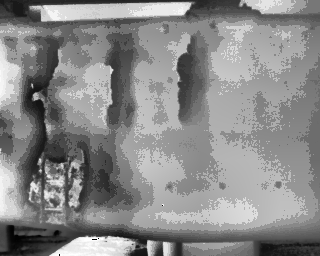

In [35]:
display(to_pil_image(input))

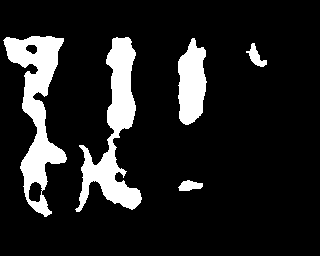

In [66]:
display(to_pil_image(target["masks"][0] * 255))